In [ ]:
##### imports #####
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
##### default values #######
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
#project indication hyperparameters
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 50

In [ ]:
###### mount drive ###### 
from google.colab import drive
drive.mount('/content/drive')
corpus = "/content/drive/MyDrive/Colab Notebooks/fra_eng.txt" 
i=0
with open(corpus) as f:
    for line in f:
        i+=1
        print(line)
        if i==4:
          break

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)

Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)

Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)

Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)



In [ ]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0
for line in open(r'/content/drive/My Drive/Colab Notebooks/fra_eng.txt', encoding="utf-8"):
  count += 1  
  if count > NUM_SENTENCES:
    break
  if '\t' not in line:
    continue
  line_split= line.rstrip().split('\t')
  input_sentence=line_split[0] ## sentence in english
  output = line_split[1] ## translation in french
  output_sentence = output + ' <eos>' #add end-of-sentence marker
  output_sentence_input = '<sos> ' + output #add start-of-sentence marker
  input_sentences.append(input_sentence)
  output_sentences.append(output_sentence)
  output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))


num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [ ]:
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

I'm hit!
Je suis touchée ! <eos>
<sos> Je suis touchée !


Tokenizer


In [ ]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 3511
Length of longest sentence in input: 6


In [ ]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 9523
Length of longest sentence in the output: 13


Padding 

In [ ]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (20000, 6)
encoder_input_sequences[172]: [  0   0   0   0   6 615]


In [ ]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (20000, 13)
decoder_input_sequences[172]: [   2    3    6 2024    5    0    0    0    0    0    0    0    0]


In [ ]:
### NOT SURE ABOUT THIS ONE ###
decoder_output_sequences= pad_sequences(output_integer_seq,maxlen=max_out_len,padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[172]:",  decoder_output_sequences[172])

decoder_output_sequences.shape: (20000, 13)
decoder_output_sequences[172]: [   3    6 2024    5    1    0    0    0    0    0    0    0    0]


Word embedding

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open(r'/content/drive/My Drive/Colab Notebooks/glove.6B.50d.txt', encoding="utf8")
for line in glove_file:
 records = line.split()
 word = records[0]
 vector_dimensions = asarray(records[1:], dtype='float32')
 embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
print(embeddings_dictionary["hit"])

[-0.41659  -0.47596   0.95744   0.27019   0.17657   0.24828  -1.2987
  0.53851   0.35336   0.58221  -0.33079  -0.5968   -0.97055   0.72084
  0.49463  -0.83398   0.12236  -0.37237  -1.4546    0.41384  -0.36311
  0.2202    0.057482 -0.24951   0.37654  -1.3061    0.22596   0.4751
  1.286    -0.62643   3.4058    0.18436   1.2656    1.0741    0.3026
  0.31395   0.33683  -0.31895   0.31912   0.37919  -1.1652    0.94625
 -0.044854 -1.0779   -0.16669   0.11604  -0.11983  -0.23663   0.29088
  0.11071 ]


Create embedding layer


In [ ]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

Model

In [ ]:
decoder_targets_one_hot = np.zeros(( len(input_sentences), max_out_len, num_words_output ), dtype='float32')

In [ ]:
decoder_targets_one_hot.shape

(20000, 13, 9524)

##Training

In [ ]:
VALIDATION_SPLIT = 0.1
LSTM_NODES = 256
BATCH_SIZE = 64

In [ ]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [ ]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))
decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [ ]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs_placeholder,
 decoder_inputs_placeholder], decoder_outputs)
model.compile(
 optimizer='rmsprop',
 loss='categorical_crossentropy',
 metrics=['accuracy']
)

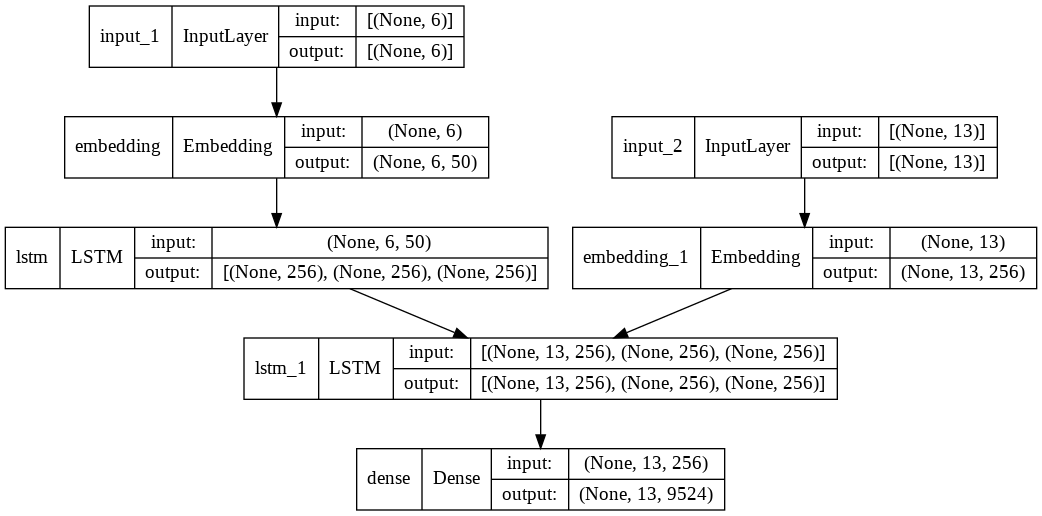

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 50)        175600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13, 256)      2438144     ['input_2[0][0]']                
                                                                                              

In [ ]:
# You should train your neural net model as shown below:
import tensorflow
import numpy as np
from tensorflow.keras.utils import Sequence
from numpy.random           import seed
from tensorflow.random      import set_seed
#-------------------------------------------------------------------------------
# These steps would not be required if you were developing the auto-translation
# project for yourself. These however, help reducing the variance induced by the
# random neural weights assigned at the beginning of the gradient descent.
# Which is useful when grading your answer
#-------------------------------------------------------------------------------
seed(42)
set_seed(42)
#
#-------------------------------------------------------------------------------
# This sequence is used to feed the training process with batches that are not
# all loaded in ram at once
#------------------------------------------------------------------------------
class LazyLoadedSequence(Sequence):
  def __init__(self, begin, end):
    self.begin      = begin        # beginning (included) of the considered data
    self.end        = end          # end (excluded) of the considered data
    self.nb_samples = end - begin  # number of data samples 

  def __len__(self):
    # returns the number of batches of data
    return np.ceil(self.nb_samples / BATCH_SIZE).astype(np.int)
  
  def __getitem__(self, idx):
    # returns the `idx`th batch of data 
    # (returns both inputs aka xs and outputs aka ys)
    start   = self.begin + BATCH_SIZE * idx
    end     = min(self.end, start + BATCH_SIZE)
    #
    enc_x   = encoder_input_sequences[start:end]
    dec_x   = decoder_input_sequences[start:end]
    one_hot = np.zeros((end-start, max_out_len, num_words_output), dtype='float16')
    # now let us actually build the one hot encoded representation for each of
    # the output sentences (in french)
    for i, d in enumerate(decoder_output_sequences[start:end]):
      for t, word in enumerate(d):
        one_hot[i, t, word] = 1
    # now return both the xs and the ys
    return [enc_x, dec_x], one_hot

#-------------------------------------------------------------------------------
# Actually fit it with custom batches
#------------------------------------------------------------------------------
nb_sentences    = len(input_sentences)
split_limit     = np.ceil(nb_sentences * (1 - VALIDATION_SPLIT)).astype(np.int)
train_data      = LazyLoadedSequence(0, split_limit)
validation_data = LazyLoadedSequence(split_limit, nb_sentences)
r = model.fit(
    train_data,
    validation_data = validation_data,
    epochs          = EPOCHS,
)

Epoch 1/20
282/282 [==============================] - 24s 61ms/step - loss: 2.1519 - accuracy: 0.7130 - val_loss: 2.1784 - val_accuracy: 0.6911
Epoch 2/20
282/282 [==============================] - 16s 56ms/step - loss: 1.7486 - accuracy: 0.7391 - val_loss: 2.0239 - val_accuracy: 0.7065
Epoch 3/20
282/282 [==============================] - 16s 56ms/step - loss: 1.5950 - accuracy: 0.7551 - val_loss: 1.9023 - val_accuracy: 0.7230
Epoch 4/20
282/282 [==============================] - 16s 56ms/step - loss: 1.4697 - accuracy: 0.7728 - val_loss: 1.8206 - val_accuracy: 0.7324
Epoch 5/20
282/282 [==============================] - 16s 56ms/step - loss: 1.3675 - accuracy: 0.7883 - val_loss: 1.7832 - val_accuracy: 0.7375
Epoch 6/20
282/282 [==============================] - 16s 56ms/step - loss: 1.2798 - accuracy: 0.7996 - val_loss: 1.7264 - val_accuracy: 0.7407
Epoch 7/20
282/282 [==============================] - 16s 56ms/step - loss: 1.2069 - accuracy: 0.8100 - val_loss: 1.6979 - val_accuracy:

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
!zip -r /content/model.zip /content/saved_model/my_model

updating: content/saved_model/my_model/ (stored 0%)
updating: content/saved_model/my_model/keras_metadata.pb (deflated 90%)
updating: content/saved_model/my_model/variables/ (stored 0%)
updating: content/saved_model/my_model/variables/variables.index (deflated 64%)
updating: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 9%)
updating: content/saved_model/my_model/saved_model.pb (deflated 90%)
updating: content/saved_model/my_model/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prediction model

In [ ]:
new_model = tensorflow.keras.models.load_model('saved_model/my_model')

In [ ]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [ ]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [ ]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [ ]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model(
 [decoder_inputs_single] + decoder_states_inputs,
 [decoder_outputs] + decoder_states
)

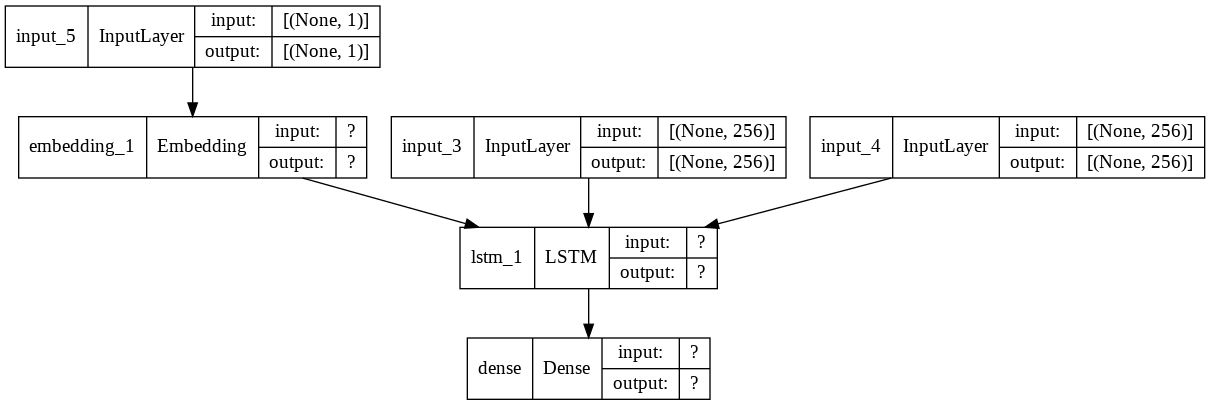

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True,
show_layer_names=True)

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        multiple             2438144     ['input_5[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 embedding (Embedding)       (None, 6, 50)             175600    
                                                                 
 lstm (LSTM)                 [(None, 256),             314368    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 489,968
Trainable params: 489,968
Non-trainable params: 0
_________________________________________________________________


In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_string,encoder,decoder):
  i = input_sentences.index(input_string)
  input_seq = encoder_input_sequences[i:i+1]
  states_value = encoder.predict(input_seq)
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = word2idx_outputs['<sos>']
  eos = word2idx_outputs['<eos>']
  output_sentence = []
  for _ in range(max_out_len):
    output_tokens, h, c = decoder.predict([target_seq] + states_value)
    idx = np.argmax(output_tokens[0, 0, :])
    if eos == idx:
      break
    word = ''
    if idx > 0:
      word = idx2word_target[idx]
      output_sentence.append(word)
    target_seq[0, 0] = idx
    states_value = [h, c]
  return ' '.join(output_sentence)

##Test model

In [ ]:
translate_sentence("I'm a lawyer.",encoder_model,decoder_model)
translate_sentence("Is anybody hurt?",encoder_model,decoder_model)
translate_sentence("I'm concentrating.",encoder_model,decoder_model)

'je suis en train de manger.'

## BLEU score evaluation

In [ ]:
import nltk

In [ ]:
reference = [['this', 'looks', 'highly', 'satisfactory', '<eos>'], ['this', 'looks', 'good', 'indeed', '<eos>' ]]
candidate = ['this', 'is', 'very', 'good', 'indeed', '<eos>']

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
sentence_bleu(reference,candidate,smoothing_function=SmoothingFunction().method1)

0.21711852081087685

In [ ]:
#### BLEU-2 SCORE 
sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0),smoothing_function=SmoothingFunction().method1)


0.5163977794943222

In [ ]:
def bleu_score2():
  score=0
  split_limit     = np.ceil(nb_sentences * (1 - VALIDATION_SPLIT)).astype(np.int)
  
  for idx in range(split_limit,len(input_sentences)):
    i=input_sentences[idx]
    print(i)
    o=output_sentences[idx]
    print(o)
    reference=[o.split()]
    print(reference)
    cand=translate_sentence(i,encoder_model,decoder_model)
    c=cand.split()
    c.append("<eos>")

    print(candidate)
    score=score+sentence_bleu(reference, c, weights=(0.5, 0.5, 0, 0),smoothing_function=SmoothingFunction().method1)
    print(score)
  score=score/(idx-split_limit)
  return score

In [ ]:
bleu_score2()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
I left you a note.
Je te laissai une note. <eos>
[['Je', 'te', 'laissai', 'une', 'note.', '<eos>']]
['this', 'is', 'very', 'good', 'indeed', '<eos>']
152.09533765385947
I left you a note.
Je vous ai laissé une note. <eos>
[['Je', 'vous', 'ai', 'laissé', 'une', 'note.', '<eos>']]
['this', 'is', 'very', 'good', 'indeed', '<eos>']
152.14273643887117
I left you a note.
Je t'ai laissé une note. <eos>
[['Je', "t'ai", 'laissé', 'une', 'note.', '<eos>']]
['this', 'is', 'very', 'good', 'indeed', '<eos>']
152.20062944561792
I let the dog out.
J'ai laissé sortir le chien. <eos>
[["J'ai", 'laissé', 'sortir', 'le', 'chien.', '<eos>']]
['this', 'is', 'very', 'good', 'indeed', '<eos>']
152.23789724524292
I lied about that.
J'ai menti à ce sujet. <eos>
[["J'ai", 'menti', 'à', 'ce', 'sujet.', '<eos>']]
['this', 'is', 'very', 'good', 'indeed', '<eos>']
152.29326566593343
I like adventures.
J'aime les aventures. <eos>
[["J'aime

0.15577231489956503

In [ ]:
split_limit     = np.ceil((1 - VALIDATION_SPLIT)).astype(np.int)
for i,o in zip(input_sentences[split_limit:],output_sentences[split_limit:]):
    reference=[o.split()]
    c=i.split()
    c.append("<eos>")
    candidate=[c]
    print(f" ref = {reference} \n cand = {candidate} \n \n")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 ref = [['Je', 'ne', 'suis', 'pas', 'triste.', '<eos>']] 
 cand = [['I', 'do', 'not', 'feel', 'sad.', '<eos>']] 
 

 ref = [['Je', 'ne', "l'accepte", 'pas.', '<eos>']] 
 cand = [['I', "don't", 'accept', 'it.', '<eos>']] 
 

 ref = [['Je', 'ne', 'te', 'le', 'reproche', 'pas.', '<eos>']] 
 cand = [['I', "don't", 'blame', 'you.', '<eos>']] 
 

 ref = [['Je', 'ne', 'vous', 'le', 'reproche', 'pas.', '<eos>']] 
 cand = [['I', "don't", 'blame', 'you.', '<eos>']] 
 

 ref = [['Je', 'ne', 'nie', 'pas', 'ceci.', '<eos>']] 
 cand = [['I', "don't", 'deny', 'this.', '<eos>']] 
 

 ref = [['Je', 'ne', 'vote', 'même', 'pas.', '<eos>']] 
 cand = [['I', "don't", 'even', 'vote.', '<eos>']] 
 

 ref = [['Je', 'ne', 'me', 'sens', 'pas', 'bien.', '<eos>']] 
 cand = [['I', "don't", 'feel', 'good.', '<eos>']] 
 

 ref = [['Je', 'ne', 'me', 'sens', 'pas', 'malade.', '<eos>']] 
 cand = [['I', "don't", 'feel', 'sick.', '<eos>']] 
 

 

In [ ]:
len(input_sentences)

20000

In [ ]:
len(output_sentences)

20000